In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# The Data

In [3]:
data = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')
data = data.dropna(subset = ['new_deaths'])

# converting date to date object
data['date'] = pd.to_datetime(data['date'])

# dropping observations before COVID-19 was detected in the country
data = data[~data['total_cases'].isna()]

# dropping redundant columns like smoothed and similar predictors
columns_to_drop = ['new_cases_smoothed',
                   'new_cases_smoothed_per_million',
                   'total_deaths',
                   'total_deaths_per_million',
                   'new_deaths_per_million',
                   'new_deaths_smoothed',
                   'new_deaths_smoothed_per_million',
                   'excess_mortality_cumulative',
                   'excess_mortality_cumulative_absolute',
                   'excess_mortality_cumulative_per_million',
                   'icu_patients',
                   'hosp_patients',
                   'weekly_icu_admissions',
                   'weekly_hosp_admissions',
                   'total_tests',
                   'new_tests',
                   'new_tests_smoothed',
                   'new_tests_smoothed_per_thousand',
                   'tests_per_case', #this is the inverse of positive_rate
                   'new_vaccinations_smoothed',
                   'total_vaccinations',
                   'people_vaccinated',
                   'people_fully_vaccinated',
                   'total_boosters',
                   'new_vaccinations_smoothed_per_million',
                   'new_people_vaccinated_smoothed']
data = data.drop(columns_to_drop,axis=1)

# filtering countries by null values in other columns
null_counts = data.groupby('location').agg(lambda x: x.isnull().sum(axis=0))
# missing_counts = data.groupby('location').apply(lambda x: x.isnull().sum())
total_null = null_counts.sum(axis=1)
null_counts['total_null'] = null_counts.sum(axis=1)
#filtering top 10 countries 
sorted_countries = null_counts[['total_null']].sort_values(by = 'total_null',ascending=True)
top_df = sorted_countries.iloc[:10]
filtered_countries_list = top_df.index.to_list()
data = data[data['location'].isin(filtered_countries_list)]
print(data.shape)
total_missing_per_country = total_null
sorted_countries = total_missing_per_country.sort_values(ascending=True)
sorted_countries.head(10)

(2007, 41)


location
United States    1008
Estonia          1104
Italy            1191
Ireland          1285
Israel           1367
Czechia          1408
Malaysia         1465
Belgium          1514
Chile            1559
France           1583
dtype: int64

# Missingness

In [4]:
# filtering data for top 10 countries with least missingness
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result_df = pd.DataFrame()
    for country in data['location'].unique():
        country_data = data[data['location'] == country]
        missing_counts = country_data.isnull().sum()
        total_missing = missing_counts.sum()
        missingness_prop = total_missing / (len(country_data)*data.shape[1])
        result_df = result_df.append({'location': country, 'total_missing': total_missing, 'missingness_prop': missingness_prop}, ignore_index=True)
    
    sorted_countries = result_df.sort_values(by='missingness_prop', ascending=False)
    print(sorted_countries.head(10))

        location  total_missing  missingness_prop
1          Chile           1559          0.189176
4         France           1583          0.186521
0        Belgium           1514          0.180131
8       Malaysia           1465          0.172617
2        Czechia           1408          0.170853
6         Israel           1367          0.163439
5        Ireland           1285          0.155928
9  United States           1008          0.142112
7          Italy           1191          0.141013
3        Estonia           1104          0.133301


In [5]:
# shrinking the original data set based on top 10 countries

top_countries = sorted_countries.head(10)
data_smaller = data[data['location'].isin(top_countries['location'])]

In [6]:
# looking at missingness in the smaller dataset

missing_values = data_smaller.isnull().sum()
missingness_prop = missing_values / len(data_smaller)
column_missingness = missing_values.to_frame(name='total_missing').join(missingness_prop.rename('missingness_prop')).sort_values(by='missingness_prop',ascending=False)

def highlight(val):
    color = 'red' if val > 0.5 else 'default'
    return f'color: {color}'

column_missingness = column_missingness.style.applymap(highlight, subset=['missingness_prop'])
column_missingness

,total_missing,missingness_prop
handwashing_facilities,2007,1.000000
total_boosters_per_hundred,996,0.496263
positive_rate,832,0.414549
new_tests_per_thousand,825,0.411061
total_tests_per_thousand,825,0.411061
tests_units,825,0.411061
weekly_icu_admissions_per_million,781,0.389138
new_vaccinations,764,0.380668
people_fully_vaccinated_per_hundred,735,0.366218
people_vaccinated_per_hundred,733,0.365222


## Missingness Comments
columns with missingness over 0.50, which we have decided warrants a closer look are total_boosters (51% missing), total_boosters_per_hundred (51% missing), and hand_washing_facilities (100% missing). Based on correlation with the target variable, if those columns have low correlation, we will remove them from the data set. 

# Constant Variables

In [7]:
# looking for constant and quasi-constant variables
num_col = data_smaller.select_dtypes(include=['number']).columns
data_num = data_smaller[num_col]
threshold = 0.95
selector = VarianceThreshold(threshold)
selector.fit(data_num)
quasi_constant_indices = data_num.columns[~selector.get_support()]
quasi_constant_indices

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Index(['reproduction_rate', 'positive_rate',
       'new_people_vaccinated_smoothed_per_hundred', 'extreme_poverty',
       'handwashing_facilities', 'human_development_index'],
      dtype='object')

## Correlation Comments
The quasi-constant variables are reproduction_rate, positive_rate, extreme_poverty, handwashing_facilities, and human_development_index. These should be removed from the dataset.

# Correlation

In [8]:
# the correlation matrix
corr = pd.DataFrame(np.abs(data.corrwith(data["new_deaths"])).sort_values(ascending=False))
corr = corr.rename(columns={0: 'Correlation with new_deaths'})
corr.style.applymap(highlight)

,Correlation with new_deaths
new_deaths,1.000000
population,0.711513
new_cases,0.642166
new_vaccinations,0.548846
weekly_icu_admissions_per_million,0.461244
male_smokers,0.372662
total_cases,0.350927
icu_patients_per_million,0.338267
weekly_hosp_admissions_per_million,0.305290
excess_mortality,0.300388


## Correlation Comments
The table above has correlations over 0.50 highlighted, but the strongest correlations with total_deaths are the ones over 0.70. These include total_cases (0.96), total_tests (0.98), new_tests (0.70), otal_vaccinations (0.98), people_vaccinated (0.98), people_fully_vaccinated (0.97), total_boosters (0.75), population (0.87), and excess_mortality_cumulative_absolute	(0.99).

In [9]:
corr['missingness_prop'] = missingness_prop
corr['low correlation/high missingness'] = (1-corr['Correlation with new_deaths'])*missingness_prop
corr.sort_values(by='low correlation/high missingness', ascending=False).style.applymap(highlight)

,Correlation with new_deaths,missingness_prop,low correlation/high missingness
new_tests_per_thousand,0.031820,0.411061,0.397981
total_tests_per_thousand,0.042468,0.411061,0.393604
positive_rate,0.068776,0.414549,0.386038
total_boosters_per_hundred,0.250674,0.496263,0.371863
people_vaccinated_per_hundred,0.198599,0.365222,0.292689
people_fully_vaccinated_per_hundred,0.220114,0.366218,0.285609
total_vaccinations_per_hundred,0.217326,0.363229,0.284290
new_people_vaccinated_smoothed_per_hundred,0.115379,0.315894,0.279447
reproduction_rate,0.104465,0.265072,0.237382
weekly_icu_admissions_per_million,0.461244,0.389138,0.209650


In the above table, we calculate features with low correlation with the target variable and high missingness. Since 'new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred' have low correlation with the target variable and high missingness, we will remove them. 

# Final Dataset Edits

In [10]:
# removing the columns specified above
features_to_remove = quasi_constant_indices.to_list()
features_to_remove.extend(['new_tests_per_thousand','total_tests_per_thousand','positive_rate','total_boosters_per_hundred'])
data = data.drop(features_to_remove, axis=1, errors='ignore')
data.shape
df = data

In [11]:
df.describe()

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
count,2.007000e+03,2.007000e+03,2007.000000,2007.000000,2007.000000,1641.000000,1600.000000,1226.000000,1767.000000,1.243000e+03,...,2007.00000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2.007000e+03,1667.000000
mean,9.011689e+06,9.784317e+04,844.764325,208375.428590,1977.096282,20.104205,134.513453,9.110152,92.965997,5.569120e+04,...,10.34805,38017.226212,155.636553,7.025874,22.264375,34.345441,3.901689,80.668137,5.151598e+07,9.743845
std,1.870686e+07,3.120448e+05,2473.030330,182302.530431,4152.403407,27.966537,137.851544,13.136121,99.951098,1.416603e+05,...,3.67124,12680.273880,63.876776,3.911759,9.040146,6.091309,1.623385,2.254464,9.077861e+07,14.588481
min,1.000000e+00,0.000000e+00,0.000000,0.021000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,3.40700,22767.037000,86.060000,3.280000,1.000000,24.600000,1.900000,76.160000,1.326064e+06,-20.600000
25%,4.747540e+05,1.540000e+03,14.000000,41577.192000,160.102500,2.787000,37.679500,1.270000,27.501500,2.115000e+02,...,7.35900,29481.252000,113.151000,4.290000,19.100000,27.800000,2.770000,78.860000,9.449000e+06,0.690000
50%,2.267099e+06,1.089900e+04,64.000000,148611.995000,655.997000,8.361000,85.504500,3.811000,63.636000,2.518000e+03,...,11.58000,33132.320000,126.459000,4.780000,24.500000,35.600000,3.180000,81.630000,1.165592e+07,6.730000
75%,5.024992e+06,5.122600e+04,394.500000,394109.788000,1987.402500,27.025000,184.063500,11.221000,120.076500,2.999100e+04,...,13.07900,42658.576000,227.485000,8.460000,30.100000,39.300000,5.640000,82.660000,5.903747e+07,14.495000
max,1.034368e+08,5.650933e+06,23312.000000,603427.621000,52358.239000,174.290000,840.672000,86.565000,703.736000,1.402874e+06,...,16.24000,67335.293000,260.942000,16.740000,34.200000,42.400000,6.630000,83.510000,3.382899e+08,105.350000


# The Target Variable: total_deaths

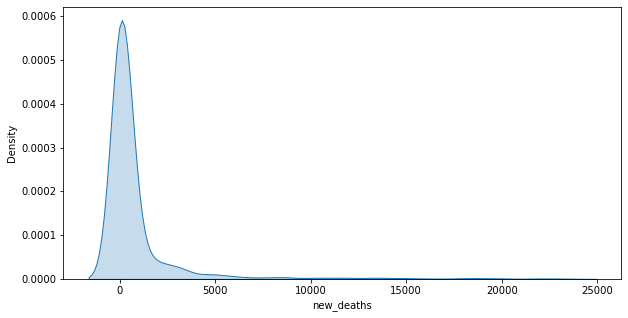

In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='new_deaths', fill=True, label='Density Plot')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 720x360 with 0 Axes>

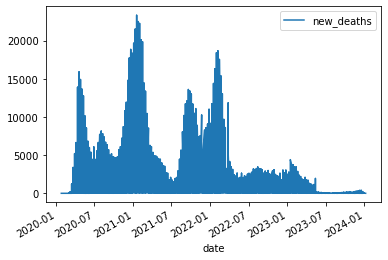

In [13]:
plt.figure(figsize=(10,5))
df.plot.line(x='date',y='new_deaths')
plt.show

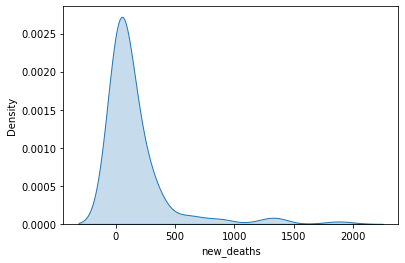

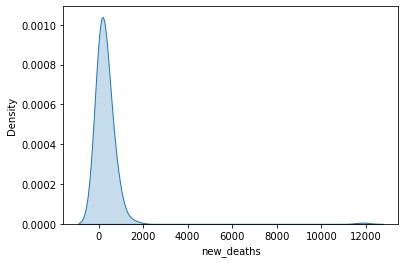

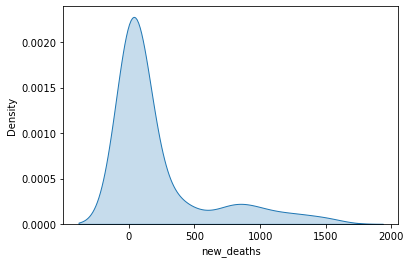

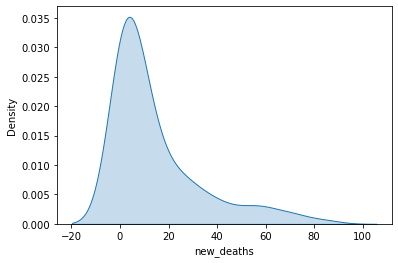

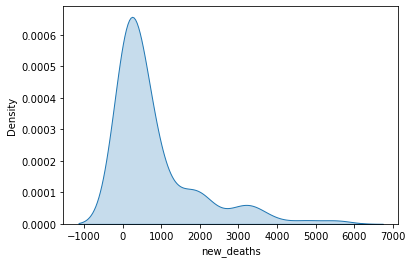

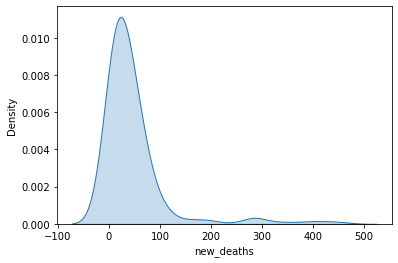

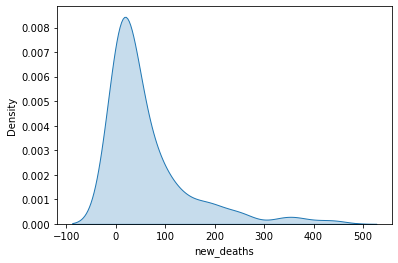

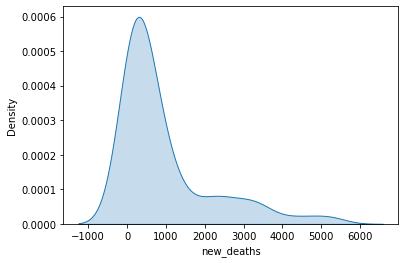

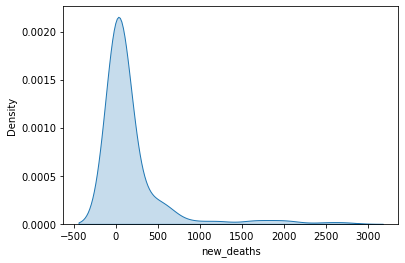

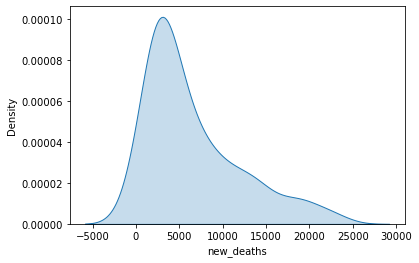

In [14]:
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    sns.kdeplot(data=country_data, x='new_deaths', fill=True)
    plt.show()

# The (Numeric) Predictors

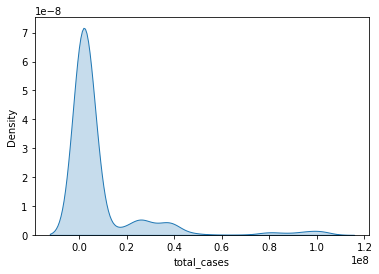

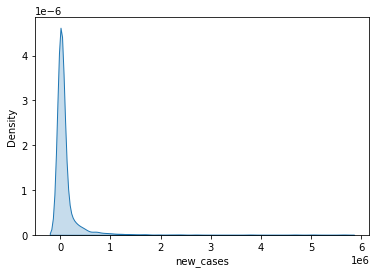

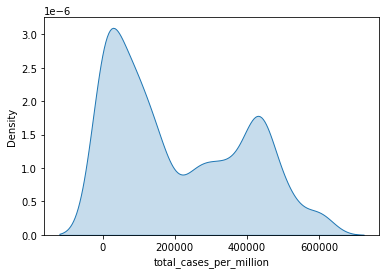

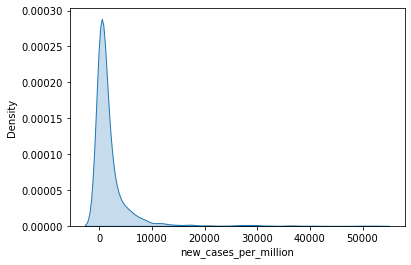

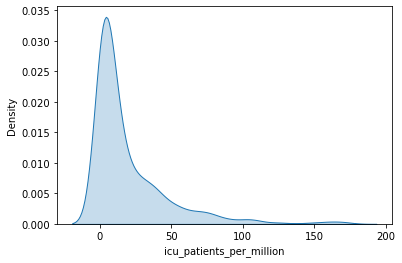

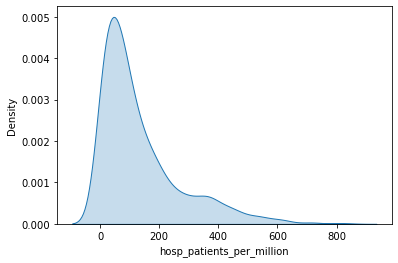

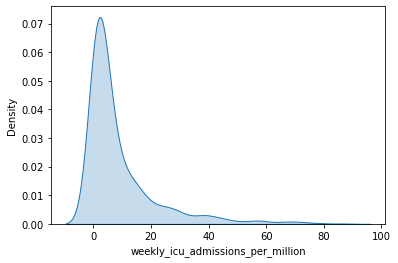

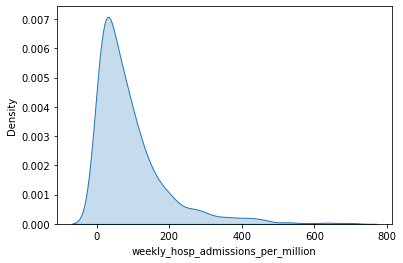

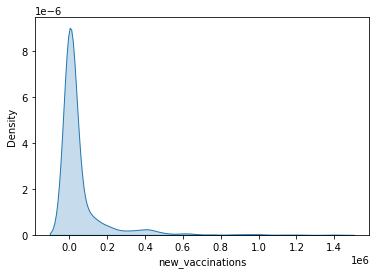

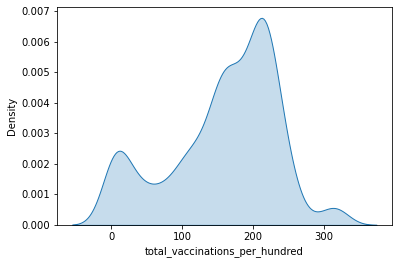

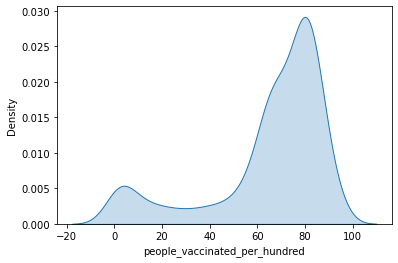

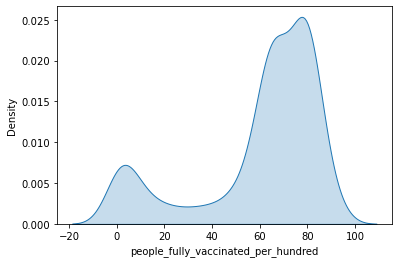

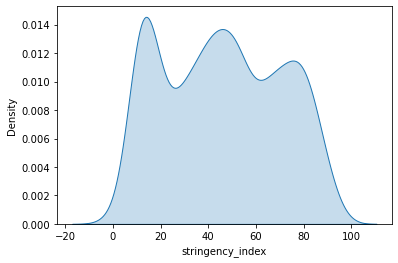

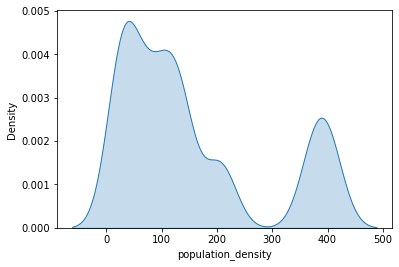

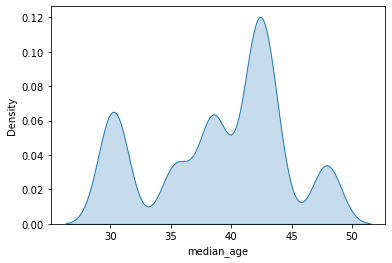

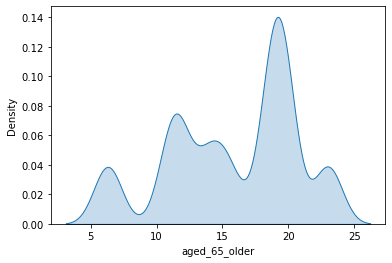

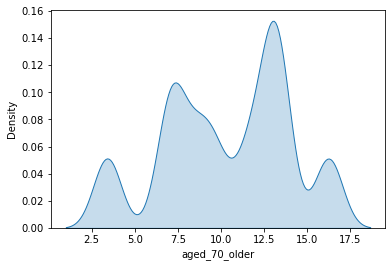

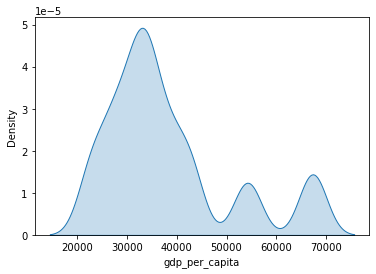

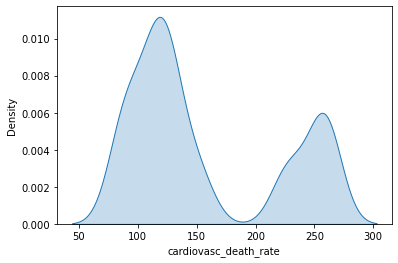

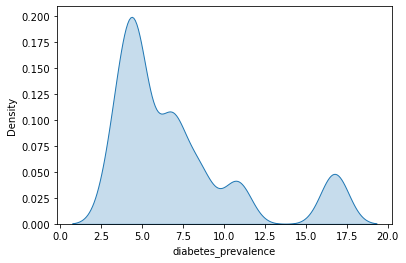

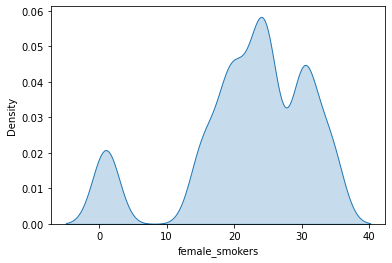

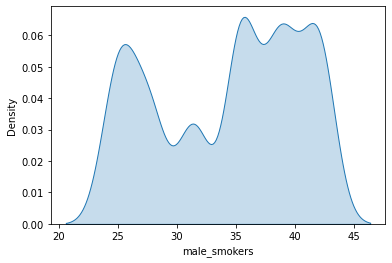

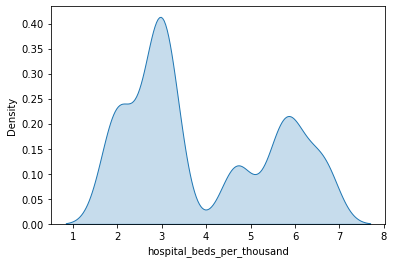

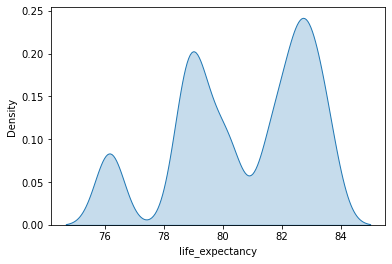

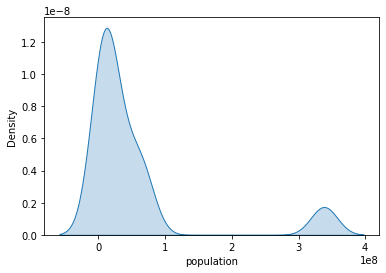

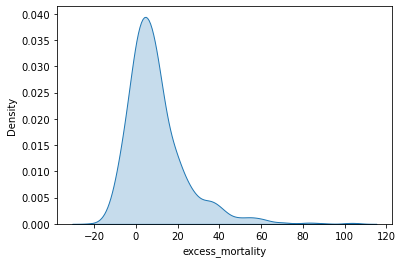

In [15]:
num_var = df.select_dtypes(include=['float64', 'int64']).columns
nontarget = [var for var in num_var if var != 'new_deaths']
for var in nontarget:
    sns.kdeplot(data=df, x=var, fill=True)
    plt.show()

# Correlations Among Predictors

In [16]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,population,excess_mortality
total_cases,1.000000,0.415566,0.350927,0.301492,0.022055,-0.064028,-0.023003,-0.117564,0.000078,0.252131,0.194886,0.229564,0.159741,-0.198333,-0.175981,0.096562,0.126015,0.109441,0.255262,-0.162831,0.145794,-0.016245,-0.382249,-0.062030,-0.024303,0.717038,-0.067415
new_cases,0.415566,1.000000,0.642166,-0.015104,0.413433,0.229137,0.279345,0.203255,0.320505,0.366236,-0.000612,0.033475,0.001586,0.004288,-0.131390,0.057125,0.076106,0.064293,0.189489,-0.101519,0.112741,-0.019940,-0.276843,-0.058448,-0.034374,0.519759,0.176917
new_deaths,0.350927,0.642166,1.000000,-0.168407,0.092862,0.338267,0.287799,0.461244,0.305290,0.548846,-0.217326,-0.198599,-0.220114,0.214413,-0.196253,0.034489,0.044958,0.028764,0.262575,-0.069508,0.192331,-0.052617,-0.372662,-0.136501,-0.119298,0.711513,0.300388
total_cases_per_million,0.301492,-0.015104,-0.168407,1.000000,0.037945,-0.390395,-0.088426,-0.343057,-0.110857,-0.296158,0.605222,0.497624,0.532659,-0.722232,0.150144,0.165171,0.236417,0.225759,0.006636,-0.120780,-0.267859,0.180625,-0.027888,0.266565,0.216691,-0.098368,-0.233509
new_cases_per_million,0.022055,0.413433,0.092862,0.037945,1.000000,0.230647,0.473047,0.272852,0.515201,0.009609,0.048575,0.047830,0.056020,-0.084783,0.052592,0.073361,0.103265,0.099840,0.012798,-0.064790,-0.103776,0.070042,-0.031484,0.097277,0.094767,-0.008098,0.219431
icu_patients_per_million,-0.064028,0.229137,0.338267,-0.390395,0.230647,1.000000,0.846243,0.949422,0.659606,0.155658,-0.525898,-0.509615,-0.527436,0.558340,-0.068072,0.045905,0.043692,0.031633,-0.058985,-0.148340,-0.044318,0.278590,0.035706,0.079403,0.043489,0.099993,0.644168
hosp_patients_per_million,-0.023003,0.279345,0.287799,-0.088426,0.473047,0.846243,1.000000,0.860815,0.838552,0.088787,-0.401823,-0.455598,-0.416032,0.289426,-0.019565,0.246702,0.282201,0.276532,-0.064967,-0.115569,-0.171075,0.257755,0.001901,0.262144,0.131212,0.039882,0.642528
weekly_icu_admissions_per_million,-0.117564,0.203255,0.461244,-0.343057,0.272852,0.949422,0.860815,1.000000,0.738604,0.050300,-0.504981,-0.525514,-0.519597,0.493872,-0.144747,0.012808,-0.012924,-0.029565,-0.218588,0.004651,0.240824,0.332332,0.261046,0.109269,-0.135979,0.124547,0.639027
weekly_hosp_admissions_per_million,0.000078,0.320505,0.305290,-0.110857,0.515201,0.659606,0.838552,0.738604,1.000000,0.153584,-0.381385,-0.401141,-0.376147,0.222615,-0.099141,0.047927,0.046289,0.023948,-0.025598,0.147722,0.049380,0.046926,0.052625,0.128311,-0.140561,0.091441,0.644117
new_vaccinations,0.252131,0.366236,0.548846,-0.296158,0.009609,0.155658,0.088787,0.050300,0.153584,1.000000,-0.270374,-0.179020,-0.253433,0.327924,-0.132133,0.000153,0.008878,0.000797,0.214583,-0.061808,0.216994,-0.155412,-0.338261,-0.195513,-0.090773,0.587191,0.065391


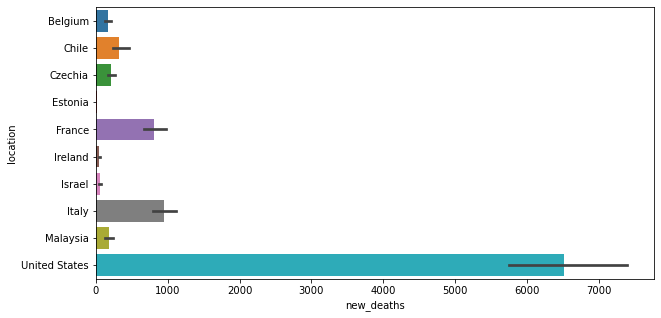

In [17]:
# Outliers Visualization

plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='new_deaths', y="location", fill=True, label='Density Plot')
plt.show()

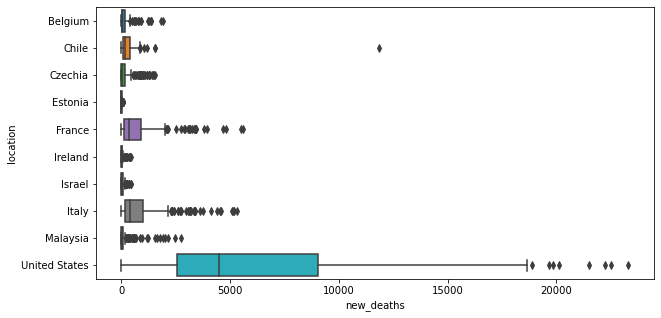

In [18]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_deaths', y="location")
plt.show()

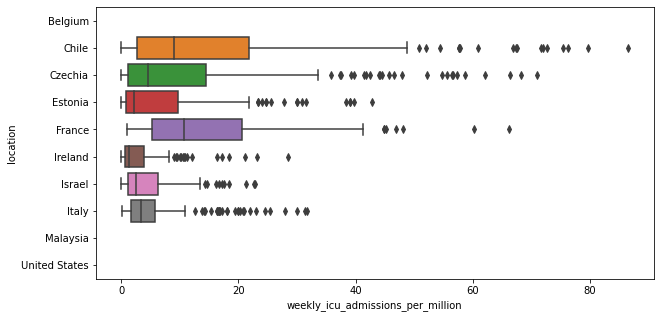

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='weekly_icu_admissions_per_million', y="location")
plt.show()

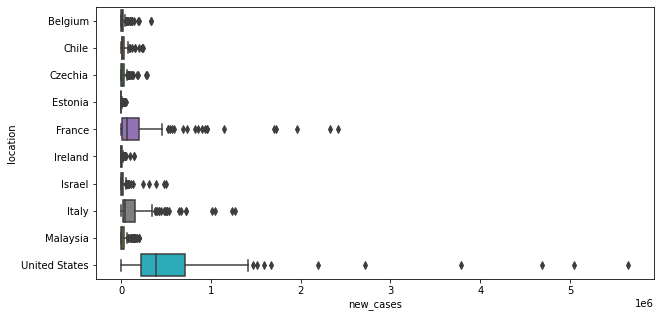

In [20]:
#new cases
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='new_cases', y="location")
plt.show()

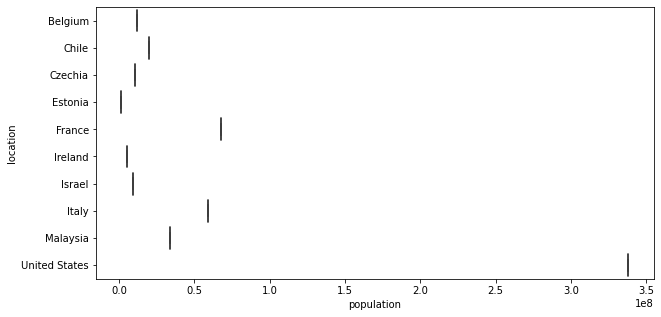

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='population', y="location")
plt.show()

# Correlation Analysis

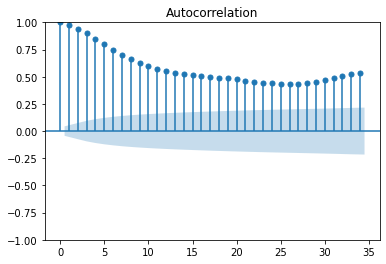

In [22]:
plot_acf(df['new_deaths'])
plt.show()

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


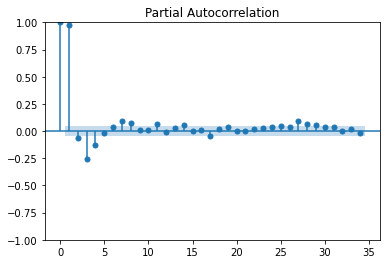

In [23]:
plot_pacf(df['new_deaths'])
plt.show()